# Model_Results
By Max Steele

In [1]:
## Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

# Custom Functions for Producing Models and Results

In [2]:
def z_outliers(df, col, cutoff=3, verbose=True):
    
    """Takes in a DataFrame and column name to calculate the
    absolute value of the z-score for each observation. 
    Returns a Series with the same index as the data with True 
    if the observation is an outlier (defined as having a z-score 
    of 3 standard deviations [default] from the mean) or False if
    the observation is not an outlier."""
    
    z_scores = np.abs(stats.zscore(df[col]))
    z_scores = pd.Series(z_scores, index=df[col].index)
    idx_outliers = z_scores > cutoff
    
    if verbose:
        print('Z-score method found {} outliers.'.format(idx_outliers.sum()))
    
    return idx_outliers

In [3]:
def build_ols(df, target, predictor):
    
    """Takes in a DataFrame and column names of the target variable and predictor.
       Returns a Statsmodels OLS regression model."""
    
    formula = target + '~' + predictor
    model = ols(formula=formula, data=df).fit()
    
    return model

In [4]:
def check_ols_assumptions(model, df, target):
    
    """Takes in a Statsmodel OLS regression model, the DataFrame from which that model was generated,
       and the target variable of that model as a string (needs to be a column name in data).
       Returns a Q-Q plot of the residuals as well as a plot of the residuals against the target
       variable to vizualize homoscedasticity of model errors."""
    
    fig, ax = plt.subplots(ncols=2,figsize=(14,5))
    ax1 = ax[0]
    ax2 = ax[1]

    sm.graphics.qqplot(model.resid, fit=True, line='45', ax=ax1, color='b')
    ax1.set_title('Q-Q Plot of Model Residuals', weight='bold', fontsize='x-large')
    ax1.set_xlabel(ax1.get_xlabel(), weight='bold')
    ax1.set_ylabel(ax1.get_ylabel(), weight='bold')

    sns.scatterplot(x=df[target], y=model.resid, ax=ax2, color='b')
    ax2.axhline(y=0, color='r')
    ax2.set_title('Homoscedasticity of Model Residuals', weight='bold', fontsize='x-large')
    ax2.set_xlabel(ax2.get_xlabel(), weight='bold')
    ax2.set_ylabel('Residual Value', weight='bold')
    
    return plt.show()

# Load Data

In [5]:
## Read in merged data directly from file
df = pd.read_csv('merged_social_data.csv')
df.head()

,Entity,Code,Year,Tax_Percent_GDP,Urban_Population
0,Afghanistan,AFG,2003,0.165953,22.353
1,Afghanistan,AFG,2004,0.411647,22.500
2,Afghanistan,AFG,2006,1.261181,22.907
3,Afghanistan,AFG,2007,1.323461,23.113
4,Afghanistan,AFG,2008,1.664719,23.320


In [6]:
## Create a DataFrame limited to the year 2017
df_2017 = df.loc[df['Year']==2017]
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 13 to 4763
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Entity            117 non-null    object 
 1   Code              117 non-null    object 
 2   Year              117 non-null    int64  
 3   Tax_Percent_GDP   117 non-null    float64
 4   Urban_Population  117 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.5+ KB


In [7]:
## Check for outliers in the dependent variable
gdp_outliers = z_outliers(df_2017, 'Tax_Percent_GDP')

Z-score method found 1 outliers.


In [8]:
## Create a new 2017 DataFrame that excludes the identified outlier
df_2017_no_outlier = df_2017[~gdp_outliers]

# Final Model Results

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

In [10]:
## Define target (dependent) variable
target = 'Tax_Percent_GDP'

## Define predictor (independent) variable
predictor = 'Urban_Population'

### Tax_Percent_GDP Outlier (Denmark) Excluded

In [11]:
## Build model on 2017 data with single GDP outlier excluded and check results summary
model = build_ols(df_2017_no_outlier, target, predictor)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Tax_Percent_GDP   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     19.99
Date:                Fri, 09 Apr 2021   Prob (F-statistic):           1.85e-05
Time:                        20:33:31   Log-Likelihood:                -312.37
No. Observations:                 116   AIC:                             628.7
Df Residuals:                     114   BIC:                             634.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.3988      0.897      3.789      0.000       1.622       5.176
Urban_Population     0.0629      0.014      4.471      0.000       0.035       0.091
==============================================================================
Omnibus:                        1.625   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.165
Skew:                           0.219   Prob(JB):                        0.558
Kurtosis:                       3.222   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both the intercept and the coefficient of the independent variable are statistically significant. However, the coefficient for `Urban_Population` is very small. Since neither the independent nor dependent variable has been transformed, the coefficient of 0.0629 suggests that for a one unit (percentage point) increase in `Urban_Population`, `Tax_Percent_GDP` tends to increase by about 0.0629 percentage points. Thus, the relationship is statistically significant, but the actual effect size is relatively tiny.

The plots below visualize the distribution of model residuals. The Q-Q plot indicates that the model residuals are relatively normally distributed. However, the assumption of residual homoscedasticity is violated because residual values exhibit a clear pattern of increase with increasing `Tax_Percent_GDP`. Ideally we would see a random scatter of points above and below the red line across all values of the dependent variable.

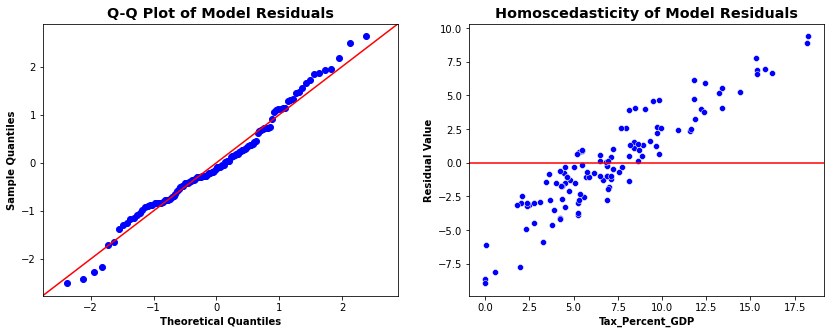

In [12]:
## Visualize normality and spread of model residuals
check_ols_assumptions(model, df_2017_no_outlier, target)